In [1]:
import pycaret
import pandas as pd

In [2]:
# อ่านไฟล์ CSV
data = pd.read_csv('../export_data_jsp01/clean_data_jsps001_1d.csv')

In [3]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [4]:
data.tail()

,humidity,pm_2_5,temperature
timestamp,,,
2025-02-07 07:00:00,72.053758,27.864365,28.186164
2025-02-08 07:00:00,72.759274,33.923883,28.104894
2025-02-09 07:00:00,69.850659,32.647832,28.231867
2025-02-10 07:00:00,69.598712,32.856690,28.338313
2025-02-11 07:00:00,71.713989,34.038326,28.029813


In [5]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
Empty DataFrame
Columns: [humidity, pm_2_5, temperature]
Index: []
ไม่มีค่าหายไปแล้ว


humidity       75.436933
pm_2_5         41.697658
temperature    30.098761
Name: 2023-09-30 07:00:00, dtype: float64

In [6]:
data = data[['pm_2_5', 'humidity', 'temperature']]

In [7]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [8]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [9]:
data['dew_point'] = data['temperature'] - ((100 - data['humidity']) / 5)

In [10]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [11]:
# อัตราส่วนของอุณหภูมิต่อความชื้น
data["temp_humidity_ratio"] = data["temperature"] / (data["humidity"] + 1)

In [12]:
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data["temperature"]
RH = data["humidity"]

data["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

In [13]:
# ความชื้นสัมพัทธ์เชิงดัชนี
data["rh_index"] = data["humidity"] ** 2 / (data["temperature"] + 1)

In [14]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# rolling_size = 1
# for i in range(2,rolling_size+1):
#     data[f'pm_2_5_rolling_{i}'] = data['pm_2_5'].rolling(window=i).mean().shift(1)

lag_size = 30
for i in range(1,lag_size+1):
    data[f'pm_2_5_lag_{i}'] = data['pm_2_5'].shift(i)

# data['humidity_rolling_2'] = data['humidity'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
# data['humidity_rolling_5'] = data['humidity'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
# data['humidity_rolling_7'] = data['humidity'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['humidity_lag_1'] = data['humidity'].shift(1)
data['humidity_lag_2'] = data['humidity'].shift(2)
data['humidity_lag_3'] = data['humidity'].shift(3)
data['humidity_lag_7'] = data['humidity'].shift(7)

# data['temperature_rolling_2'] = data['temperature'].rolling(window=2).mean().shift(1)  # ค่าเฉลี่ย 2 วันของ PM 10
# data['temperature_rolling_5'] = data['temperature'].rolling(window=5).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10
# data['temperature_rolling_7'] = data['temperature'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 7 วันของ PM 10

data['temperature_lag_1'] = data['temperature'].shift(1)
data['temperature_lag_2'] = data['temperature'].shift(2)
data['temperature_lag_3'] = data['temperature'].shift(3)
data['temperature_lag_7'] = data['temperature'].shift(7)

In [16]:
data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4',
       'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7', 'pm_2_5_lag_8',
       'pm_2_5_lag_9', 'pm_2_5_lag_10', 'pm_2_5_lag_11', 'pm_2_5_lag_12',
       'pm_2_5_lag_13', 'pm_2_5_lag_14', 'pm_2_5_lag_15', 'pm_2_5_lag_16',
       'pm_2_5_lag_17', 'pm_2_5_lag_18', 'pm_2_5_lag_19', 'pm_2_5_lag_20',
       'pm_2_5_lag_21', 'pm_2_5_lag_22', 'pm_2_5_lag_23', 'pm_2_5_lag_24',
       'pm_2_5_lag_25', 'pm_2_5_lag_26', 'pm_2_5_lag_27', 'pm_2_5_lag_28',
       'pm_2_5_lag_29', 'pm_2_5_lag_30', 'humidity_lag_1', 'humidity_lag_2',
       'humidity_lag_3', 'humidity_lag_7', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', '

In [17]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

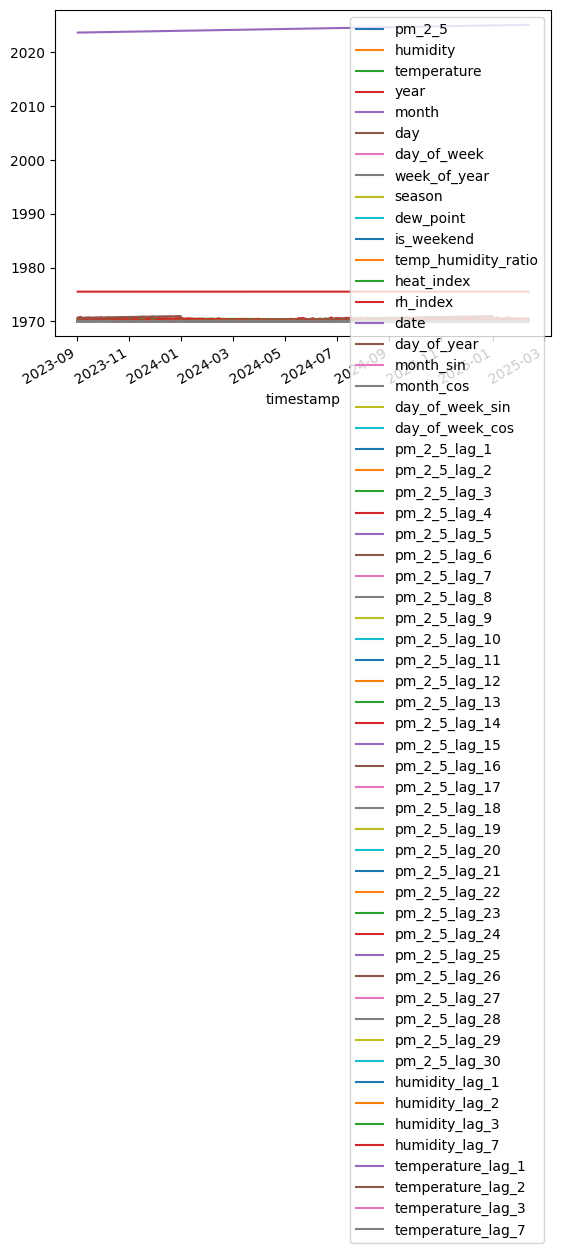

In [18]:
data_filtered.plot()

In [21]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.05660377358490566

In [22]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [23]:
train_data.shape

(500, 58)

In [24]:
test_data.shape

(30, 58)

In [25]:
test_data.head(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,pm_2_5_lag_29,pm_2_5_lag_30,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,30.592321,75.720718,24.857799,2025,1,13,0,3,2,20.001942,...,5.556624,7.502461,76.964691,73.407775,74.018696,85.925103,26.640566,28.05223,28.380074,25.455684


In [26]:
test_data.tail(1)

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,pm_2_5_lag_29,pm_2_5_lag_30,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,34.038326,71.713989,28.029813,2025,2,11,1,7,0,22.37261,...,30.592321,30.049163,69.598712,69.850659,72.759274,71.844422,28.338313,28.231867,28.104894,27.531455


In [27]:
test_data.tail()

,pm_2_5,humidity,temperature,year,month,day,day_of_week,week_of_year,season,dew_point,...,pm_2_5_lag_29,pm_2_5_lag_30,humidity_lag_1,humidity_lag_2,humidity_lag_3,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-07 07:00:00,27.864365,72.053758,28.186164,2025,2,7,4,6,0,22.596916,...,37.902901,38.080407,70.853854,70.575618,71.844422,68.361925,28.150220,27.676822,27.531455,27.174035
2025-02-08 07:00:00,33.923883,72.759274,28.104894,2025,2,8,5,6,0,22.656749,...,39.917015,37.902901,72.053758,70.853854,70.575618,73.127154,28.186164,28.150220,27.676822,26.538196
2025-02-09 07:00:00,32.647832,69.850659,28.231867,2025,2,9,6,6,0,22.201998,...,28.920126,39.917015,72.759274,72.053758,70.853854,74.573612,28.104894,28.186164,28.150220,26.578263
2025-02-10 07:00:00,32.856690,69.598712,28.338313,2025,2,10,0,7,0,22.258056,...,30.049163,28.920126,69.850659,72.759274,72.053758,66.783050,28.231867,28.104894,28.186164,27.428759
2025-02-11 07:00:00,34.038326,71.713989,28.029813,2025,2,11,1,7,0,22.372610,...,30.592321,30.049163,69.598712,69.850659,72.759274,71.844422,28.338313,28.231867,28.104894,27.531455


In [28]:
test_data.columns

Index(['pm_2_5', 'humidity', 'temperature', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'season', 'dew_point', 'is_weekend',
       'temp_humidity_ratio', 'heat_index', 'rh_index', 'date', 'day_of_year',
       'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
       'pm_2_5_lag_1', 'pm_2_5_lag_2', 'pm_2_5_lag_3', 'pm_2_5_lag_4',
       'pm_2_5_lag_5', 'pm_2_5_lag_6', 'pm_2_5_lag_7', 'pm_2_5_lag_8',
       'pm_2_5_lag_9', 'pm_2_5_lag_10', 'pm_2_5_lag_11', 'pm_2_5_lag_12',
       'pm_2_5_lag_13', 'pm_2_5_lag_14', 'pm_2_5_lag_15', 'pm_2_5_lag_16',
       'pm_2_5_lag_17', 'pm_2_5_lag_18', 'pm_2_5_lag_19', 'pm_2_5_lag_20',
       'pm_2_5_lag_21', 'pm_2_5_lag_22', 'pm_2_5_lag_23', 'pm_2_5_lag_24',
       'pm_2_5_lag_25', 'pm_2_5_lag_26', 'pm_2_5_lag_27', 'pm_2_5_lag_28',
       'pm_2_5_lag_29', 'pm_2_5_lag_30', 'humidity_lag_1', 'humidity_lag_2',
       'humidity_lag_3', 'humidity_lag_7', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', '

In [29]:
# from pycaret.time_series import *
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='pm_2_5', session_id=123, fold=12, iterative_imputation_iters=100, remove_outliers = True)
# iterative_imputation_iters=100, remove_outliers = True

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(500, 58)"
4,Transformed data shape,"(482, 60)"
5,Transformed train set shape,"(332, 60)"
6,Transformed test set shape,"(150, 60)"
7,Numeric features,56
8,Date features,1
9,Preprocess,True


In [30]:
# compare baseline models
best = exp1.compare_models(n_select=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,5.1151,43.0593,6.4771,0.5448,0.2740,0.2446,0.0325
llar,Lasso Least Angle Regression,5.3201,45.5561,6.6808,0.5158,0.2826,0.2546,0.0250
et,Extra Trees Regressor,5.2701,45.1895,6.6462,0.5146,0.2827,0.2581,0.0708
lasso,Lasso Regression,5.3474,46.0356,6.7170,0.5101,0.2843,0.2563,0.0267
br,Bayesian Ridge,5.3674,46.3425,6.7470,0.5060,0.2848,0.2571,0.0242
en,Elastic Net,5.3757,46.9307,6.7889,0.4987,0.2877,0.2568,0.0258
rf,Random Forest Regressor,5.3701,47.5757,6.8306,0.4885,0.2907,0.2631,0.1258
huber,Huber Regressor,5.4711,48.3581,6.8813,0.4837,0.2867,0.2548,0.0325
ada,AdaBoost Regressor,5.4873,48.6036,6.9026,0.4807,0.2988,0.2786,0.0392
lightgbm,Light Gradient Boosting Machine,5.5222,49.4561,6.9629,0.4701,0.2932,0.2632,0.0783


In [47]:
# model_1 = exp1.create_model('rf')
model_1 = exp1.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.5460,68.1008,8.2523,0.2721,0.3292,0.3113
1,6.1738,67.0389,8.1877,0.4049,0.3096,0.2379
2,6.7697,57.2846,7.5687,0.3661,0.3381,0.3505
3,4.5627,33.9078,5.8230,0.6922,0.2379,0.2211
4,4.2250,30.0891,5.4854,0.6808,0.2325,0.1821
5,5.3090,42.4315,6.5139,0.5534,0.2880,0.2466
6,3.7355,26.1855,5.1172,0.6963,0.1938,0.1600
7,5.2300,51.8504,7.2007,0.4456,0.2986,0.2309
8,5.6377,50.5930,7.1129,0.4487,0.3613,0.3680


In [31]:
# exp1.evaluate_model(model_1)

In [70]:
model_2 = exp1.create_model('omp')
model_3 = exp1.create_model('lightgbm')
model_4 = exp1.create_model('br')
model_5 = exp1.create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.1725,57.9818,7.6146,0.3803,0.3230,0.3157
1,6.7310,75.1236,8.6674,0.3332,0.3284,0.2552
2,5.8987,48.1382,6.9382,0.4673,0.3047,0.2881
3,4.0425,28.2607,5.3161,0.7435,0.2245,0.1904
4,3.7563,24.6455,4.9644,0.7386,0.2308,0.1731
5,5.6002,42.9709,6.5552,0.5477,0.2815,0.2596
6,3.9661,28.6865,5.3560,0.6673,0.1903,0.1605
7,5.0991,50.2676,7.0900,0.4625,0.2880,0.2249
8,4.9062,39.3487,6.2729,0.5712,0.3111,0.3085


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.5633,65.9975,8.1239,0.2946,0.3271,0.3048
1,6.3506,70.5738,8.4008,0.3736,0.3165,0.2339
2,5.8133,45.2209,6.7246,0.4996,0.3134,0.3067
3,5.1656,43.9939,6.6328,0.6007,0.2667,0.2287
4,4.4314,32.1664,5.6715,0.6588,0.2257,0.1868
5,5.1803,39.6068,6.2934,0.5831,0.2702,0.2413
6,3.6226,24.4557,4.9453,0.7164,0.1930,0.1540
7,6.0029,56.7514,7.5334,0.3931,0.3162,0.2658
8,5.9083,53.9700,7.3464,0.4119,0.3597,0.3629


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.0348,56.6879,7.5291,0.3941,0.3225,0.3081
1,6.5581,72.7679,8.5304,0.3541,0.3137,0.2447
2,5.8617,50.1598,7.0824,0.4450,0.2980,0.2812
3,4.7776,32.9561,5.7407,0.7009,0.2414,0.2214
4,3.8892,26.0027,5.0993,0.7242,0.2373,0.1759
5,5.6650,44.9327,6.7032,0.5271,0.2860,0.2626
6,4.4431,34.3533,5.8612,0.6016,0.2149,0.1826
7,5.4144,53.6436,7.3242,0.4264,0.2952,0.2349
8,5.1173,41.0542,6.4074,0.5526,0.3308,0.3296


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.9235,72.0529,8.4884,0.2299,0.3437,0.3345
1,6.3120,63.9117,7.9945,0.4327,0.2845,0.2278
2,6.1794,54.4797,7.3810,0.3972,0.3292,0.3230
3,5.2654,49.5192,7.0370,0.5505,0.2806,0.2473
4,4.2053,27.6198,5.2555,0.7070,0.2311,0.1920
5,5.1316,42.4509,6.5154,0.5532,0.2723,0.2371
6,4.1493,29.0054,5.3857,0.6636,0.1940,0.1675
7,5.8842,56.7546,7.5336,0.3931,0.3128,0.2730
8,5.3631,45.1264,6.7176,0.5083,0.3400,0.3421


In [71]:
new_data = test_data.copy().drop(['pm_2_5'], axis=1)
predictions = exp1.predict_model(model_5, data=new_data)
predict_v = predictions['prediction_label']
real = test_data['pm_2_5']

# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

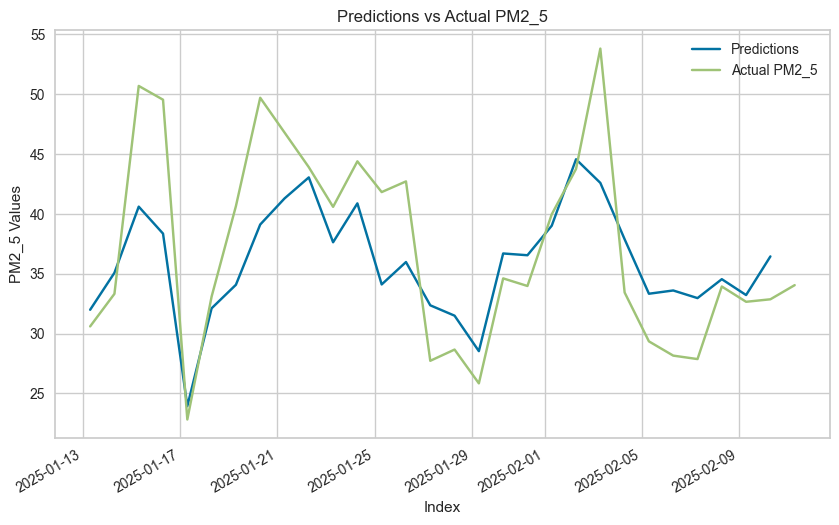

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v.shift(-1), test_data['pm_2_5']], axis=1)
result.columns = ['Predictions', 'Actual PM2_5']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2_5')
plt.xlabel('Index')
plt.ylabel('PM2_5 Values')

# แสดงกราฟ
plt.show()

In [73]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Extract actual values and predicted values
y_true = test_data["pm_2_5"][:"2025-2-10"]
y_pred = predict_v.shift(-1).dropna(axis=0)

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: 0.5797
Mean Absolute Error (MAE): 4.2214
Root Mean Squared Error (RMSE): 5.3356
Mean Absolute Percentage Error (MAPE): 10.87%
Accuracy: 89.13%


# Predict 1 by 1

30 วัน  
2025-01-13 07:00:00  
2025-02-11 07:00:00  
7 วัน  
2025-02-05  
2025-02-11  
24 วัน  
2025-01-19 07:00:00  
31 วัน
2025-01-12 07:00:00

In [ ]:
# exp1.save_model(model_1, "pm2_5_model_1")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['date'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['humidity', 'temperature', 'year',
                                              'month', 'day', 'day_of_week',
                                              'week_of_year', 'season',
                                              'dew_point', 'is_weekend',
                                              'temp_humidity_ratio',
                                              'heat_index', 'rh_index'...
                                              'pm_2_5_lag_8', 'pm_2_5_lag_9',
                                              'pm_2_5_lag_10', 'pm_2_5_lag_11',
                                              'pm_2_5_lag_12', ...],
                                     transformer=SimpleImputer())),
   

In [74]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

model = model_5

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'pm_2_5_lag_{i}'] = data_compare['pm_2_5'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['pm_2_5'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'pm_2_5'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

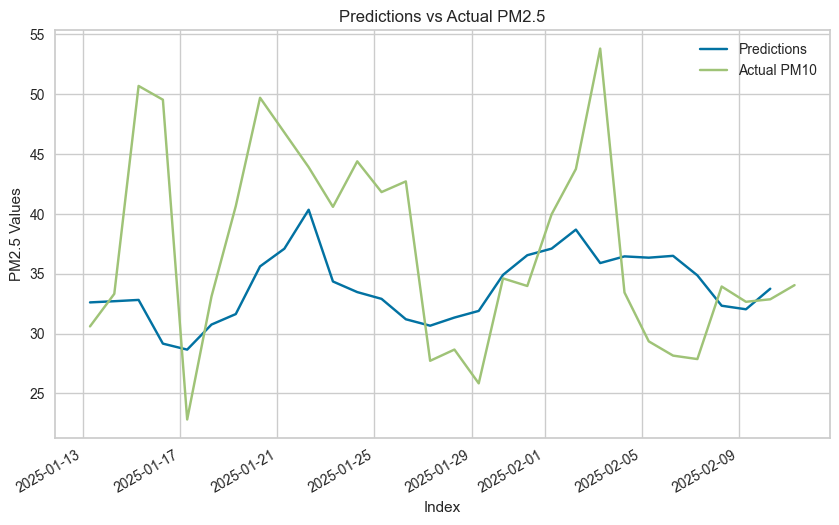

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['pm_2_5']], axis=1)
result_plot.columns = ['Predictions', 'Actual PM10']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2.5')
plt.xlabel('Index')
plt.ylabel('PM2.5 Values')

# แสดงกราฟ
plt.show()

In [76]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = real_data["pm_2_5"][:"2025-2-10"]
y_pred = result['prediction_label'].shift(-1).dropna(axis=0)# "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: -0.0832
Mean Absolute Error (MAE): 6.6123
Root Mean Squared Error (RMSE): 8.5661
Mean Absolute Percentage Error (MAPE): 16.75%
Accuracy: 83.25%


In [78]:
exp1.save_model(model_5, 'gbr_pm_2_5_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['date'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['humidity', 'temperature', 'year',
                                              'month', 'day', 'day_of_week',
                                              'week_of_year', 'season',
                                              'dew_point', 'is_weekend',
                                              'temp_humidity_ratio',
                                              'heat_index', 'rh_index'...
                                              'pm_2_5_lag_8', 'pm_2_5_lag_9',
                                              'pm_2_5_lag_10', 'pm_2_5_lag_11',
                                              'pm_2_5_lag_12', ...],
                                     transformer=SimpleImputer())),
   

# GEN ALL MODEL 

Processing model: OrthogonalMatchingPursuit


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.0413,9.2498,3.0413,nan,0.1012,0.0994


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.6244,13.1360,3.6244,nan,0.1116,0.1088


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,19.8754,395.0301,19.8754,nan,0.4855,0.3922


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,18.8933,356.9556,18.8933,nan,0.4684,0.3815


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,7.4344,55.2701,7.4344,nan,0.2716,0.3258


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,7.8345,61.3801,7.8345,nan,0.2612,0.2368


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,20.1232,404.9414,20.1232,nan,0.6603,0.4952


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,28.9323,837.0770,28.9323,nan,0.8459,0.5823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,21.6073,466.8771,21.6073,nan,0.6018,0.4618


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,13.0048,169.1248,13.0048,nan,0.3421,0.2963


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,9.6481,93.0856,9.6481,nan,0.2640,0.2378


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,13.4280,180.3103,13.4280,nan,0.3509,0.3026


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,9.2380,85.3398,9.2380,nan,0.2431,0.2210


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,13.1405,172.6729,13.1405,nan,0.3577,0.3077


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.5905,0.3487,0.5905,nan,0.0204,0.0213


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.4440,5.9730,2.4440,nan,0.0792,0.0853


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,5.7805,33.4138,5.7805,nan,0.1951,0.2237


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.4069,11.6071,3.4069,nan,0.1006,0.0985


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,2.2662,5.1358,2.2662,nan,0.0670,0.0667


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,10.3344,106.7998,10.3344,nan,0.2908,0.2587


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,15.5753,242.5892,15.5753,nan,0.4279,0.3561


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,25.4426,647.3273,25.4426,nan,0.6243,0.4730


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.9695,24.6960,4.9695,nan,0.1559,0.1487


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,0.2815,0.0792,0.2815,nan,0.0093,0.0096


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.0901,1.1883,1.0901,nan,0.0367,0.0387


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,1.2482,1.5580,1.2482,nan,0.0423,0.0448


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,5.8766,34.5341,5.8766,nan,0.1842,0.1732


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,5.9715,35.6592,5.9715,nan,0.1954,0.1829


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,6.5461,42.8511,6.5461,nan,0.2149,0.1992


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,6.8437,46.8359,6.8437,nan,0.2173,0.2011


Processing model: LassoLars


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.7434,3.0395,1.7434,nan,0.0568,0.0570


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.2475,10.5460,3.2475,nan,0.0994,0.0975


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,20.6596,426.8188,20.6596,nan,0.5105,0.4077


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,20.6778,427.5728,20.6778,nan,0.5264,0.4176


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.7081,22.1663,4.7081,nan,0.1804,0.2063


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,9.9144,98.2949,9.9144,nan,0.3437,0.2997


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,20.2208,408.8820,20.2208,nan,0.6649,0.4976


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,25.2343,636.7706,25.2343,nan,0.6889,0.5079


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,19.0191,361.7269,19.0191,nan,0.5075,0.4065


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,12.2636,150.3948,12.2636,nan,0.3191,0.2794


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,7.7717,60.3997,7.7717,nan,0.2069,0.1915


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,12.1779,148.3001,12.1779,nan,0.3125,0.2744


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,8.0578,64.9277,8.0578,nan,0.2085,0.1927


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,10.7016,114.5242,10.7016,nan,0.2809,0.2506


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.0579,9.3506,3.0579,nan,0.1012,0.1103


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,5.5653,30.9731,5.5653,nan,0.1720,0.1942


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,6.1595,37.9400,6.1595,nan,0.2066,0.2384


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.0334,16.2686,4.0334,nan,0.1202,0.1166


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.8953,0.8015,0.8953,nan,0.0259,0.0264


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,10.1358,102.7344,10.1358,nan,0.2843,0.2537


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,15.3882,236.7980,15.3882,nan,0.4215,0.3518


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,22.5725,509.5175,22.5725,nan,0.5310,0.4196


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,3.1644,10.0136,3.1644,nan,0.0964,0.0947


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,0.0423,0.0018,0.0423,nan,0.0014,0.0014


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.9154,3.6687,1.9154,nan,0.0636,0.0680


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,1.0557,1.1145,1.0557,nan,0.0359,0.0379


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,6.1034,37.2515,6.1034,nan,0.1921,0.1799


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.2528,18.0865,4.2528,nan,0.1351,0.1303


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.2138,17.7558,4.2138,nan,0.1329,0.1282


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,4.9492,24.4949,4.9492,nan,0.1523,0.1454


Processing model: ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,4.2756,18.2811,4.2756,nan,0.1269,0.1398


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.8436,0.7116,0.8436,nan,0.0249,0.0253


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,17.3806,302.0855,17.3806,nan,0.4100,0.3430


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,13.6149,185.3645,13.6149,nan,0.3140,0.2749


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.6128,112.6309,10.6128,nan,0.3685,0.4651


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5972,0.3566,0.5972,nan,0.0174,0.0181


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,6.4876,42.0887,6.4876,nan,0.1694,0.1597


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,15.2503,232.5703,15.2503,nan,0.3579,0.3069


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,13.4489,180.8717,13.4489,nan,0.3305,0.2875


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.1150,102.3137,10.1150,nan,0.2553,0.2305


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,6.3230,39.9806,6.3230,nan,0.1650,0.1558


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,9.4172,88.6839,9.4172,nan,0.2326,0.2122


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.1546,51.1888,7.1546,nan,0.1829,0.1711


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.1800,51.5530,7.1800,nan,0.1795,0.1681


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,6.9141,47.8042,6.9141,nan,0.2157,0.2494


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,4.4055,19.4086,4.4055,nan,0.1385,0.1537


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.1904,51.7020,7.1904,nan,0.2374,0.2783


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.7996,3.2384,1.7996,nan,0.0519,0.0520


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.5274,0.2782,0.5274,nan,0.0152,0.0155


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.1771,4.7399,2.1771,nan,0.0546,0.0545


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,6.6501,44.2241,6.6501,nan,0.1609,0.1520


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,16.6304,276.5705,16.6304,nan,0.3617,0.3092


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1807,0.0327,0.1807,nan,0.0052,0.0054


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,5.4622,29.8353,5.4622,nan,0.1655,0.1861


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.1433,51.0274,7.1433,nan,0.2192,0.2537


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,9.7798,95.6441,9.7798,nan,0.2918,0.3510


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.6669,13.4462,3.6669,nan,0.0998,0.1081


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,4.6516,21.6378,4.6516,nan,0.1295,0.1425


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.3681,11.3441,3.3681,nan,0.0948,0.1025


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.8288,0.6869,0.8288,nan,0.0239,0.0243


Processing model: Lasso


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.7413,3.0322,1.7413,nan,0.0567,0.0569


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.2424,10.5133,3.2424,nan,0.0993,0.0973


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,20.6555,426.6515,20.6555,nan,0.5104,0.4076


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,20.6741,427.4200,20.6741,nan,0.5263,0.4175


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.7133,22.2157,4.7133,nan,0.1806,0.2065


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,9.9155,98.3173,9.9155,nan,0.3438,0.2997


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,20.2215,408.9071,20.2215,nan,0.6649,0.4976


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,25.2306,636.5819,25.2306,nan,0.6888,0.5078


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,19.0148,361.5634,19.0148,nan,0.5074,0.4064


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,12.2597,150.3010,12.2597,nan,0.3190,0.2793


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,7.7697,60.3676,7.7697,nan,0.2069,0.1915


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,12.1736,148.1959,12.1736,nan,0.3124,0.2743


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,8.0510,64.8179,8.0510,nan,0.2083,0.1926


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,10.6961,114.4061,10.6961,nan,0.2807,0.2505


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.0643,9.3902,3.0643,nan,0.1014,0.1105


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,5.5715,31.0418,5.5715,nan,0.1722,0.1944


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,6.1653,38.0106,6.1653,nan,0.2068,0.2386


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.0277,16.2222,4.0277,nan,0.1201,0.1164


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.8895,0.7912,0.8895,nan,0.0258,0.0262


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,10.1316,102.6487,10.1316,nan,0.2842,0.2536


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,15.3834,236.6502,15.3834,nan,0.4214,0.3517


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,22.5675,509.2929,22.5675,nan,0.5308,0.4195


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.1586,9.9769,3.1586,nan,0.0962,0.0945


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,0.0470,0.0022,0.0470,nan,0.0015,0.0016


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.9200,3.6863,1.9200,nan,0.0638,0.0682


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,1.0602,1.1240,1.0602,nan,0.0361,0.0380


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,6.0996,37.2051,6.0996,nan,0.1920,0.1798


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.2491,18.0552,4.2491,nan,0.1350,0.1302


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.2086,17.7126,4.2086,nan,0.1327,0.1281


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,4.9441,24.4437,4.9441,nan,0.1521,0.1452


Processing model: BayesianRidge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.3787,5.6580,2.3787,nan,0.0783,0.0778


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.9045,15.2454,3.9045,nan,0.1208,0.1172


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,20.1691,406.7932,20.1691,nan,0.4948,0.3980


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,20.1959,407.8757,20.1959,nan,0.5104,0.4078


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.4157,19.4985,4.4157,nan,0.1701,0.1935


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,10.8769,118.3069,10.8769,nan,0.3844,0.3288


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,20.6991,428.4520,20.6991,nan,0.6875,0.5094


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,24.8384,616.9460,24.8384,nan,0.6735,0.4999


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,19.6863,387.5519,19.6863,nan,0.5310,0.4208


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,12.7289,162.0254,12.7289,nan,0.3335,0.2900


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,8.0821,65.3209,8.0821,nan,0.2162,0.1992


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,13.6216,185.5491,13.6216,nan,0.3569,0.3070


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,7.6871,59.0909,7.6871,nan,0.1979,0.1839


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,10.0372,100.7463,10.0372,nan,0.2609,0.2351


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.3215,5.3895,2.3215,nan,0.0777,0.0837


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,5.8770,34.5391,5.8770,nan,0.1808,0.2051


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,5.9327,35.1973,5.9327,nan,0.1997,0.2296


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,5.5194,30.4633,5.5194,nan,0.1685,0.1595


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.7676,3.1244,1.7676,nan,0.0519,0.0520


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,10.6598,113.6321,10.6598,nan,0.3015,0.2668


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,15.8602,251.5456,15.8602,nan,0.4377,0.3626


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,22.1927,492.5155,22.1927,nan,0.5193,0.4126


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.6656,7.1055,2.6656,nan,0.0806,0.0798


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0135,0.0002,0.0135,nan,0.0004,0.0005


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.3776,5.6529,2.3776,nan,0.0784,0.0845


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.2323,1.5186,1.2323,nan,0.0418,0.0442


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,6.1117,37.3526,6.1117,nan,0.1924,0.1802


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.9019,15.2245,3.9019,nan,0.1233,0.1195


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.8375,14.7261,3.8375,nan,0.1203,0.1168


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,5.1526,26.5495,5.1526,nan,0.1591,0.1514


Processing model: ElasticNet


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.2134,4.8990,2.2134,nan,0.0726,0.0724


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.5047,12.2827,3.5047,nan,0.1077,0.1052


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,20.4590,418.5703,20.4590,nan,0.5041,0.4037


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,20.3095,412.4746,20.3095,nan,0.5142,0.4101


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,5.0675,25.6797,5.0675,nan,0.1929,0.2221


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,11.2193,125.8736,11.2193,nan,0.3992,0.3391


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,21.6278,467.7636,21.6278,nan,0.7328,0.5322


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,25.3990,645.1079,25.3990,nan,0.6954,0.5112


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,19.3199,373.2574,19.3199,nan,0.5180,0.4129


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,12.0433,145.0403,12.0433,nan,0.3124,0.2744


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,7.3937,54.6668,7.3937,nan,0.1958,0.1822


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,12.7032,161.3718,12.7032,nan,0.3284,0.2863


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,7.2807,53.0084,7.2807,nan,0.1864,0.1741


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,9.9987,99.9744,9.9987,nan,0.2598,0.2342


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.0699,9.4246,3.0699,nan,0.1016,0.1107


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,6.4463,41.5553,6.4463,nan,0.1967,0.2249


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,6.3776,40.6739,6.3776,nan,0.2132,0.2468


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,4.8582,23.6020,4.8582,nan,0.1467,0.1404


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.1526,1.3284,1.1526,nan,0.0335,0.0339


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,10.6067,112.5012,10.6067,nan,0.2997,0.2655


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,15.9784,255.3084,15.9784,nan,0.4418,0.3653


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,22.3377,498.9749,22.3377,nan,0.5237,0.4153


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.3427,5.4881,2.3427,nan,0.0705,0.0701


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,0.1199,0.0144,0.1199,nan,0.0039,0.0041


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,2.6211,6.8702,2.6211,nan,0.0861,0.0931


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,1.4626,2.1391,1.4626,nan,0.0494,0.0525


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,6.1607,37.9542,6.1607,nan,0.1941,0.1816


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,4.3151,18.6200,4.3151,nan,0.1372,0.1322


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.7344,13.9454,3.7344,nan,0.1169,0.1137


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,4.8057,23.0944,4.8057,nan,0.1475,0.1412


Processing model: RandomForestRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.8170,7.9354,2.8170,nan,0.0854,0.0921


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.1870,1.4090,1.1870,nan,0.0340,0.0356


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,15.6426,244.6901,15.6426,nan,0.3606,0.3087


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,15.0150,225.4494,15.0150,nan,0.3527,0.3032


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.1710,84.1077,9.1710,nan,0.3257,0.4019


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.4583,0.2100,0.4583,nan,0.0135,0.0139


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.4912,90.0824,9.4912,nan,0.2587,0.2336


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,18.4149,339.1079,18.4149,nan,0.4515,0.3706


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,14.8155,219.5002,14.8155,nan,0.3711,0.3167


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,10.2670,105.4109,10.2670,nan,0.2597,0.2339


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.6497,21.6199,4.6497,nan,0.1186,0.1146


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,8.4800,71.9104,8.4800,nan,0.2069,0.1911


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,6.1126,37.3644,6.1126,nan,0.1541,0.1462


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,6.2218,38.7108,6.2218,nan,0.1536,0.1457


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7.3987,54.7415,7.3987,nan,0.2292,0.2669


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,3.1742,10.0754,3.1742,nan,0.1017,0.1108


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.4087,29.2546,5.4087,nan,0.1836,0.2093


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.3450,5.4989,2.3450,nan,0.0681,0.0678


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3614,0.1306,0.3614,nan,0.0103,0.0106


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.4089,19.4382,4.4089,nan,0.1139,0.1103


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7.2352,52.3475,7.2352,nan,0.1764,0.1654


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,16.7342,280.0319,16.7342,nan,0.3644,0.3111


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,3.1494,9.9186,3.1494,nan,0.0875,0.0942


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7.0671,49.9444,7.0671,nan,0.2094,0.2408


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.3348,87.1394,9.3348,nan,0.2778,0.3316


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.3525,87.4693,9.3525,nan,0.2807,0.3356


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.2336,4.9892,2.2336,nan,0.0620,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.7652,7.6465,2.7652,nan,0.0790,0.0847


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.8193,0.6713,0.8193,nan,0.0239,0.0249


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.4676,0.2187,0.4676,nan,0.0134,0.0137


Processing model: HuberRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.1666,0.0277,0.1666,nan,0.0053,0.0054


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.2415,0.0583,0.2415,nan,0.0071,0.0073


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,16.3034,265.8024,16.3034,nan,0.3791,0.3217


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,17.6008,309.7886,17.6008,nan,0.4283,0.3554


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,4.9078,24.0861,4.9078,nan,0.1873,0.2151


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,10.9199,119.2443,10.9199,nan,0.3862,0.3301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,21.5409,464.0104,21.5409,nan,0.7285,0.5301


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,24.0307,577.4732,24.0307,nan,0.6427,0.4837


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,15.7127,246.8877,15.7127,nan,0.3987,0.3358


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,6.0919,37.1108,6.0919,nan,0.1458,0.1388


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.9866,0.9733,0.9866,nan,0.0240,0.0243


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,8.6292,74.4627,8.6292,nan,0.2109,0.1945


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,5.3043,28.1359,5.3043,nan,0.1323,0.1269


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,8.2783,68.5306,8.2783,nan,0.2100,0.1939


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,4.6161,21.3086,4.6161,nan,0.1490,0.1665


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,10.4232,108.6429,10.4232,nan,0.3012,0.3637


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,13.0067,169.1749,13.0067,nan,0.3952,0.5034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.9461,0.8951,0.9461,nan,0.0262,0.0273


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.4946,2.2337,1.4946,nan,0.0419,0.0440


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,8.1829,66.9598,8.1829,nan,0.2229,0.2048


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,14.7199,216.6763,14.7199,nan,0.3990,0.3365


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,22.0284,485.2490,22.0284,nan,0.5142,0.4095


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.6279,0.3942,0.6279,nan,0.0184,0.0188


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.3815,5.6715,2.3815,nan,0.0756,0.0812


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,2.4116,5.8156,2.4116,nan,0.0795,0.0857


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.0912,0.0083,0.0912,nan,0.0032,0.0033


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,7.8960,62.3466,7.8960,nan,0.2563,0.2328


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,5.6086,31.4564,5.6086,nan,0.1823,0.1718


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,3.3060,10.9295,3.3060,nan,0.1027,0.1006


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,1.7770,3.1576,1.7770,nan,0.0520,0.0522


Processing model: AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,2.5501,6.5032,2.5501,nan,0.0776,0.0834


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.5511,0.3038,0.5511,nan,0.0159,0.0165


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,15.7821,249.0753,15.7821,nan,0.3645,0.3115


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,15.7260,247.3061,15.7260,nan,0.3729,0.3176


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,10.0639,101.2824,10.0639,nan,0.3524,0.4410


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.0838,0.0070,0.0838,nan,0.0025,0.0025


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,7.4928,56.1428,7.4928,nan,0.1984,0.1844


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,18.9187,357.9177,18.9187,nan,0.4672,0.3808


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,14.4817,209.7209,14.4817,nan,0.3610,0.3095


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,8.9976,80.9569,8.9976,nan,0.2237,0.2050


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,2.9398,8.6424,2.9398,nan,0.0733,0.0724


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,8.4862,72.0150,8.4862,nan,0.2070,0.1912


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,6.4277,41.3148,6.4277,nan,0.1627,0.1537


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,9.4985,90.2219,9.4985,nan,0.2451,0.2224


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,5.1634,26.6611,5.1634,nan,0.1653,0.1863


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,5.2064,27.1062,5.2064,nan,0.1617,0.1817


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,9.0540,81.9751,9.0540,nan,0.2907,0.3504


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.5416,2.3766,1.5416,nan,0.0424,0.0446


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,3.6702,13.4706,3.6702,nan,0.0998,0.1081


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,4.5736,20.9179,4.5736,nan,0.1184,0.1145


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,9.2765,86.0532,9.2765,nan,0.2324,0.2121


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,15.8697,251.8469,15.8697,nan,0.3420,0.2950


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,2.0184,4.0740,2.0184,nan,0.0570,0.0604


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,6.1000,37.2105,6.1000,nan,0.1832,0.2079


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,10.2096,104.2364,10.2096,nan,0.3003,0.3626


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,8.0376,64.6034,8.0376,nan,0.2457,0.2885


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.9666,3.8677,1.9666,nan,0.0548,0.0580


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,3.2542,10.5895,3.2542,nan,0.0923,0.0997


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,3.0453,9.2738,3.0453,nan,0.0861,0.0927


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,1.6389,2.6859,1.6389,nan,0.0457,0.0481


Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2207,4.9317,2.2207,nan,0.0679,0.0726


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.0336,4.1354,2.0336,nan,0.0576,0.0610


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,15.2104,231.3571,15.2104,nan,0.3487,0.3002


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,16.1925,262.1956,16.1925,nan,0.3864,0.3270


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.7053,114.6028,10.7053,nan,0.3712,0.4691


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.8269,0.6837,0.8269,nan,0.0240,0.0250


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,7.3195,53.5747,7.3195,nan,0.1933,0.1801


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,13.7472,188.9858,13.7472,nan,0.3164,0.2767


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.4325,88.9721,9.4325,nan,0.2199,0.2016


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,6.8853,47.4080,6.8853,nan,0.1665,0.1569


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.5229,0.2734,0.5229,nan,0.0127,0.0129


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,8.6204,74.3116,8.6204,nan,0.2107,0.1943


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,6.5290,42.6279,6.5290,nan,0.1655,0.1562


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,5.2752,27.8276,5.2752,nan,0.1286,0.1235


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,8.2339,67.7976,8.2339,nan,0.2521,0.2970


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.1878,84.4156,9.1878,nan,0.2699,0.3206


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.1170,83.1194,9.1170,nan,0.2925,0.3529


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.8532,3.4344,1.8532,nan,0.0507,0.0536


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,7.7538,60.1213,7.7538,nan,0.2003,0.2283


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.3257,0.1061,0.3257,nan,0.0079,0.0082


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.9416,15.5362,3.9416,nan,0.0922,0.0901


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.9164,98.3349,9.9164,nan,0.1997,0.1843


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,7.4997,56.2462,7.4997,nan,0.1971,0.2244


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,8.4850,71.9945,8.4850,nan,0.2466,0.2892


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.9856,120.6839,10.9856,nan,0.3198,0.3902


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,8.5261,72.6941,8.5261,nan,0.2588,0.3060


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.7245,0.5249,0.7245,nan,0.0205,0.0214


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,5.5595,30.9077,5.5595,nan,0.1529,0.1703


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,7.2757,52.9360,7.2757,nan,0.1947,0.2214


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.9102,8.4695,2.9102,nan,0.0798,0.0855


Processing model: GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,3.0646,9.3917,3.0646,nan,0.0926,0.1002


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.7166,0.5135,0.7166,nan,0.0211,0.0215


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,17.9765,323.1555,17.9765,nan,0.4275,0.3548


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,16.7170,279.4579,16.7170,nan,0.4018,0.3376


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,6.3345,40.1261,6.3345,nan,0.2358,0.2776


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,4.4298,19.6227,4.4298,nan,0.1392,0.1339


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,9.8889,97.7902,9.8889,nan,0.2712,0.2434


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,18.0612,326.2052,18.0612,nan,0.4406,0.3635


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,11.1813,125.0225,11.1813,nan,0.2666,0.2390


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,6.8077,46.3445,6.8077,nan,0.1645,0.1551


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2434,0.0592,0.2434,nan,0.0059,0.0060


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.0334,100.6701,10.0334,nan,0.2499,0.2261


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8.3510,69.7386,8.3510,nan,0.2170,0.1997


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,9.8084,96.2051,9.8084,nan,0.2542,0.2297


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,3.4695,12.0374,3.4695,nan,0.1140,0.1252


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1.9931,3.9724,1.9931,nan,0.0650,0.0695


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,5.4939,30.1828,5.4939,nan,0.1862,0.2126


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.7156,7.3745,2.7156,nan,0.0793,0.0785


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.9271,0.8595,0.9271,nan,0.0262,0.0273


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,3.4170,11.6757,3.4170,nan,0.0871,0.0855


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,6.6518,44.2467,6.6518,nan,0.1610,0.1521


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,15.1163,228.5018,15.1163,nan,0.3228,0.2810


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2.4575,6.0393,2.4575,nan,0.0690,0.0735


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,7.0965,50.3607,7.0965,nan,0.2102,0.2418


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8.1778,66.8772,8.1778,nan,0.2473,0.2905


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8.6201,74.3057,8.6201,nan,0.2613,0.3094


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.9308,0.8663,0.9308,nan,0.0263,0.0274


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.3288,0.1081,0.3288,nan,0.0098,0.0101


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.8343,0.6960,0.8343,nan,0.0250,0.0254


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2990,0.0894,0.2990,nan,0.0086,0.0088


Processing model: KNeighborsRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,2.9619,8.7727,2.9619,nan,0.0896,0.0968


  File "d:\Normal File\Coder\MINI_PROJECT_1-2\pycaret_venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,4.3740,19.1318,4.3740,nan,0.1200,0.1313


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,8.7156,75.9619,8.7156,nan,0.1847,0.1720


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,8.4158,70.8260,8.4158,nan,0.1822,0.1699


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,17.3755,301.9072,17.3755,nan,0.5478,0.7614


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,7.1111,50.5680,7.1111,nan,0.1895,0.2149


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,10.3489,107.0988,10.3489,nan,0.2858,0.2547


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,18.4201,339.3019,18.4201,nan,0.4517,0.3707


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,17.0198,289.6724,17.0198,nan,0.4403,0.3638


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9.4932,90.1200,9.4932,nan,0.2376,0.2163


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,3.5439,12.5593,3.5439,nan,0.0891,0.0873


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,10.9928,120.8416,10.9928,nan,0.2774,0.2477


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,8.3946,70.4694,8.3946,nan,0.2183,0.2008


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9.2868,86.2444,9.2868,nan,0.2389,0.2175


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9.0894,82.6173,9.0894,nan,0.2750,0.3279


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,4.7232,22.3083,4.7232,nan,0.1478,0.1648


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.5564,0.3096,0.5564,nan,0.0205,0.0215


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,8.2091,67.3900,8.2091,nan,0.2621,0.2372


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,6.8922,47.5026,6.8922,nan,0.2195,0.2029


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,4.8503,23.5250,4.8503,nan,0.1261,0.1214


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,8.6343,74.5513,8.6343,nan,0.2144,0.1974


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,12.4456,154.8920,12.4456,nan,0.2577,0.2314


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,7.9191,62.7120,7.9191,nan,0.2070,0.2369


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,12.0007,144.0174,12.0007,nan,0.3333,0.4090


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,16.6735,278.0070,16.6735,nan,0.4523,0.5922


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,14.0042,196.1171,14.0042,nan,0.3955,0.5026


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,7.9447,63.1177,7.9447,nan,0.2050,0.2342


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,8.0630,65.0120,8.0630,nan,0.2148,0.2470


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,2.0317,4.1278,2.0317,nan,0.0583,0.0618


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,2.8903,8.3541,2.8903,nan,0.0861,0.0849


Processing model: Ridge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,6.6441,44.1441,6.6441,nan,0.2361,0.2172


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,10.4714,109.6504,10.4714,nan,0.3641,0.3143


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,24.5018,600.3375,24.5018,nan,0.6428,0.4835


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,18.6077,346.2483,18.6077,nan,0.4594,0.3758


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,9.4385,89.0857,9.4385,nan,0.3338,0.4136


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,9.8059,96.1552,9.8059,nan,0.3393,0.2964


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,26.1208,682.2955,26.1208,nan,0.9872,0.6428


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,30.4832,929.2230,30.4832,nan,0.9199,0.6135


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,23.6450,559.0876,23.6450,nan,0.6828,0.5054


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,15.3062,234.2785,15.3062,nan,0.4170,0.3488


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,12.5875,158.4454,12.5875,nan,0.3606,0.3102


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,17.4688,305.1576,17.4688,nan,0.4861,0.3936


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,8.1931,67.1273,8.1931,nan,0.2124,0.1960


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,11.1076,123.3796,11.1076,nan,0.2933,0.2601


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.5148,2.2946,1.5148,nan,0.0514,0.0546


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.8559,8.1560,2.8559,nan,0.0919,0.0997


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.5922,0.3506,0.5922,nan,0.0218,0.0229


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,14.2363,202.6720,14.2363,nan,0.5106,0.4114


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,11.5636,133.7176,11.5636,nan,0.4015,0.3404


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,16.6160,276.0906,16.6160,nan,0.5204,0.4159


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,16.1747,261.6203,16.1747,nan,0.4487,0.3698


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,19.7389,389.6243,19.7389,nan,0.4467,0.3670


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.3630,11.3098,3.3630,nan,0.0932,0.1006


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,5.1645,26.6726,5.1645,nan,0.1572,0.1760


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,10.2404,104.8668,10.2404,nan,0.3010,0.3637


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,7.8989,62.3930,7.8989,nan,0.2419,0.2835


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.8181,0.6692,0.8181,nan,0.0237,0.0241


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.5997,2.5589,1.5997,nan,0.0487,0.0490


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.1849,10.1435,3.1849,nan,0.0988,0.0969


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.6235,13.1300,3.6235,nan,0.1092,0.1065


Processing model: DecisionTreeRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,17.7838,316.2636,17.7838,nan,0.8276,0.5813


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,9.1613,83.9289,9.1613,nan,0.3106,0.2750


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,34.6799,1202.6967,34.6799,nan,1.1121,0.6844


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,38.2249,1461.1439,38.2249,nan,1.4131,0.7719


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.3326,1.7759,1.3326,nan,0.0544,0.0584


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,1.1551,1.3343,1.1551,nan,0.0333,0.0349


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,27.8268,774.3302,27.8268,nan,1.1037,0.6848


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,35.7676,1279.3209,35.7676,nan,1.2231,0.7199


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,32.8696,1080.4124,32.8696,nan,1.1643,0.7026


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,32.5003,1056.2692,32.5003,nan,1.2875,0.7405


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,29.2903,857.9195,29.2903,nan,1.2190,0.7218


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,32.9415,1085.1434,32.9415,nan,1.2945,0.7423


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,17.6564,311.7488,17.6564,nan,0.5318,0.4223


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,11.8478,140.3694,11.8478,nan,0.3162,0.2775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.5794,0.3357,0.5794,nan,0.0204,0.0209


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,2.2973,5.2776,2.2973,nan,0.0806,0.0802


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7.9943,63.9087,7.9943,nan,0.3537,0.3094


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7.8391,61.4512,7.8391,nan,0.2487,0.2265


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,13.6372,185.9740,13.6372,nan,0.4943,0.4015


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,26.1427,683.4395,26.1427,nan,1.0170,0.6543


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,22.7539,517.7387,22.7539,nan,0.7105,0.5202


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,33.4618,1119.6954,33.4618,nan,0.9434,0.6221


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,15.5824,242.8100,15.5824,nan,0.6027,0.4662


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7.0133,49.1863,7.0133,nan,0.2628,0.2390


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,5.8237,33.9158,5.8237,nan,0.2228,0.2069


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,15.0095,225.2855,15.0095,nan,0.7340,0.5387


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,23.5559,554.8808,23.5559,nan,1.1224,0.6944


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,22.2799,496.3920,22.2799,nan,1.0851,0.6824


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,15.8116,250.0072,15.8116,nan,0.6293,0.4812


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,12.5944,158.6182,12.5944,nan,0.4454,0.3700


Processing model: DummyRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,6.4318,41.3678,6.4318,nan,0.2276,0.2102


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,9.1530,83.7782,9.1530,nan,0.3103,0.2748


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,26.5121,702.8892,26.5121,nan,0.7197,0.5232


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,25.3608,643.1686,25.3608,nan,0.6971,0.5121


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,1.3408,1.7979,1.3408,nan,0.0548,0.0588


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,8.9235,79.6293,8.9235,nan,0.3036,0.2697


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,16.4748,271.4178,16.4748,nan,0.5037,0.4054


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,25.5235,651.4481,25.5235,nan,0.7003,0.5137


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,22.6255,511.9138,22.6255,nan,0.6415,0.4836


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,19.7275,389.1760,19.7275,nan,0.5789,0.4495


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,16.4165,269.5007,16.4165,nan,0.5023,0.4046


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,20.2162,408.6927,20.2162,nan,0.5897,0.4556


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,17.6482,311.4584,17.6482,nan,0.5315,0.4221


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,18.5404,343.7452,18.5404,nan,0.5521,0.4342


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,3.5596,12.6710,3.5596,nan,0.1323,0.1284


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,4.4978,20.2304,4.4978,nan,0.1645,0.1569


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,1.6759,2.8087,1.6759,nan,0.0645,0.0649


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,10.4415,109.0246,10.4415,nan,0.3471,0.3018


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,9.8065,96.1666,9.8065,nan,0.3291,0.2887


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,15.7941,249.4546,15.7941,nan,0.4872,0.3953


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,19.5782,383.3050,19.5782,nan,0.5756,0.4476


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,29.6311,878.0009,29.6311,nan,0.7783,0.5508


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,9.2640,85.8217,9.2640,nan,0.3135,0.2772


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,5.1824,26.8569,5.1824,nan,0.1873,0.1766


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,3.9928,15.9424,3.9928,nan,0.1473,0.1418


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,3.7038,13.7183,3.7038,nan,0.1373,0.1329


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,9.7633,95.3228,9.7633,nan,0.3279,0.2878


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,8.4873,72.0340,8.4873,nan,0.2907,0.2600


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,8.6961,75.6230,8.6961,nan,0.2969,0.2647


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,9.8778,97.5706,9.8778,nan,0.3312,0.2902


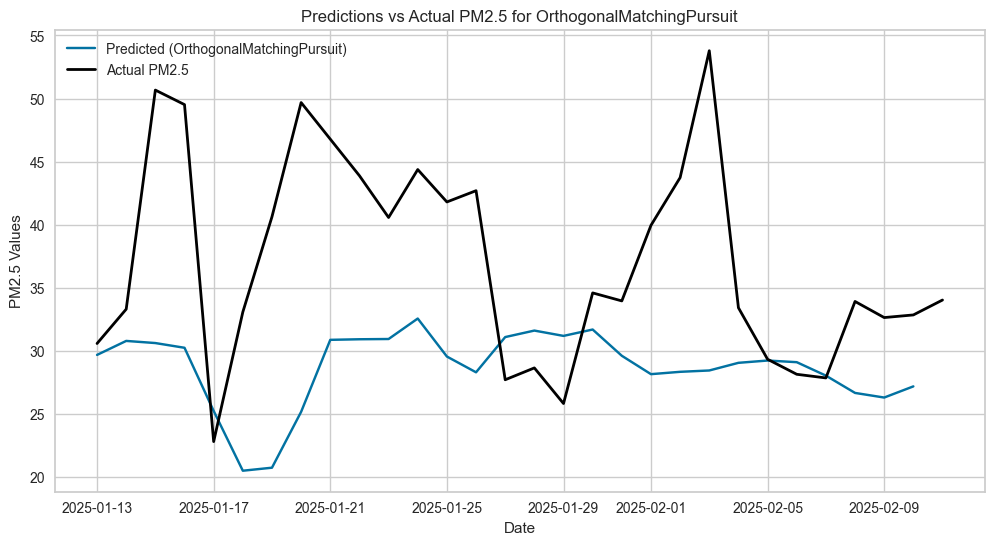

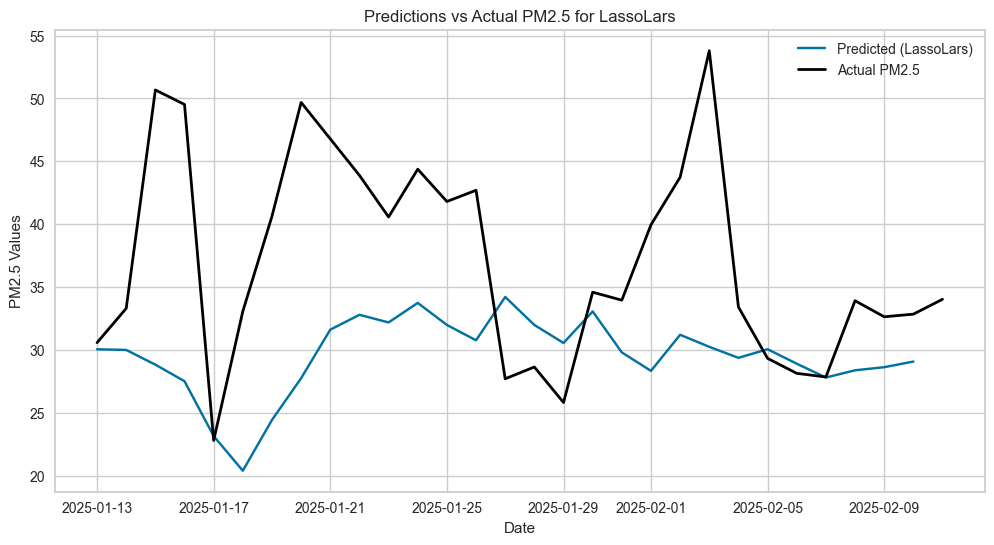

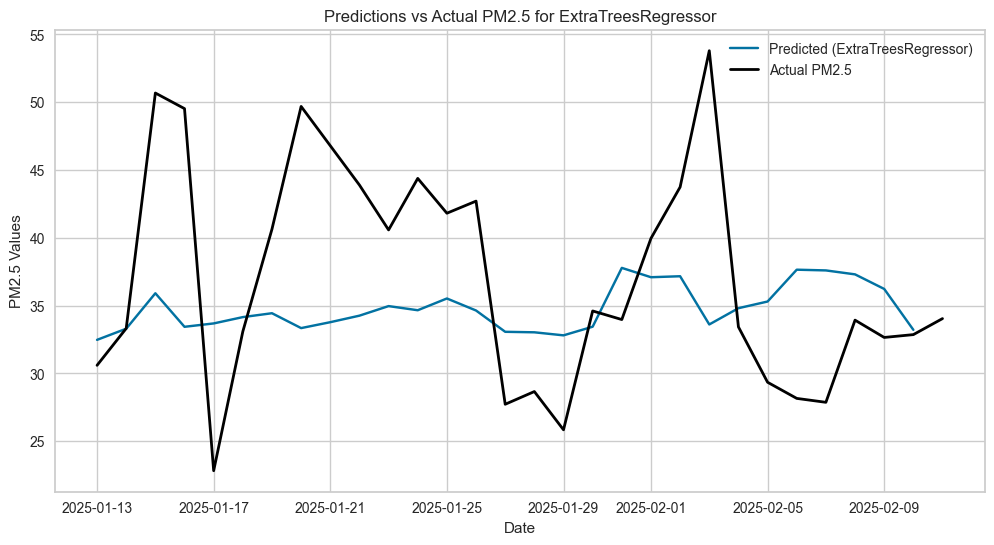

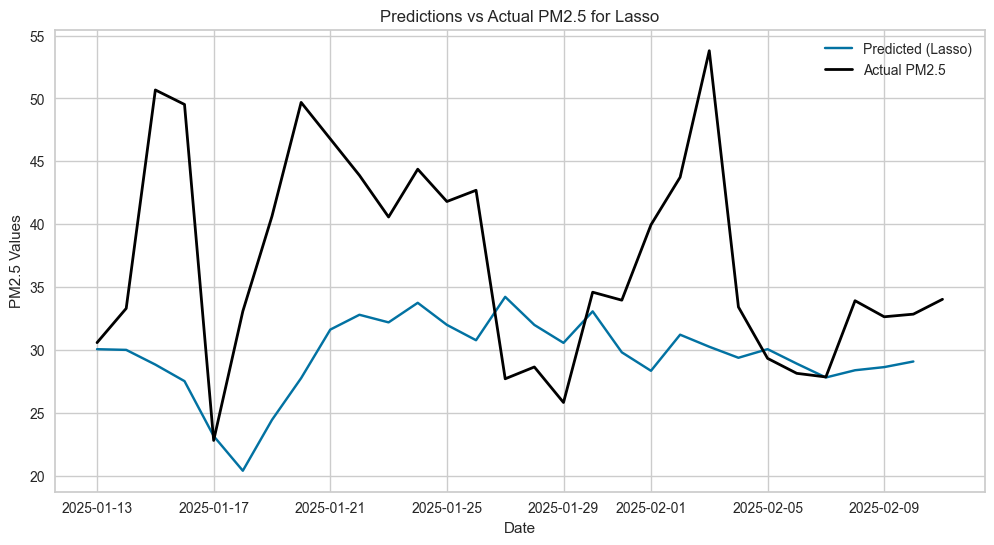

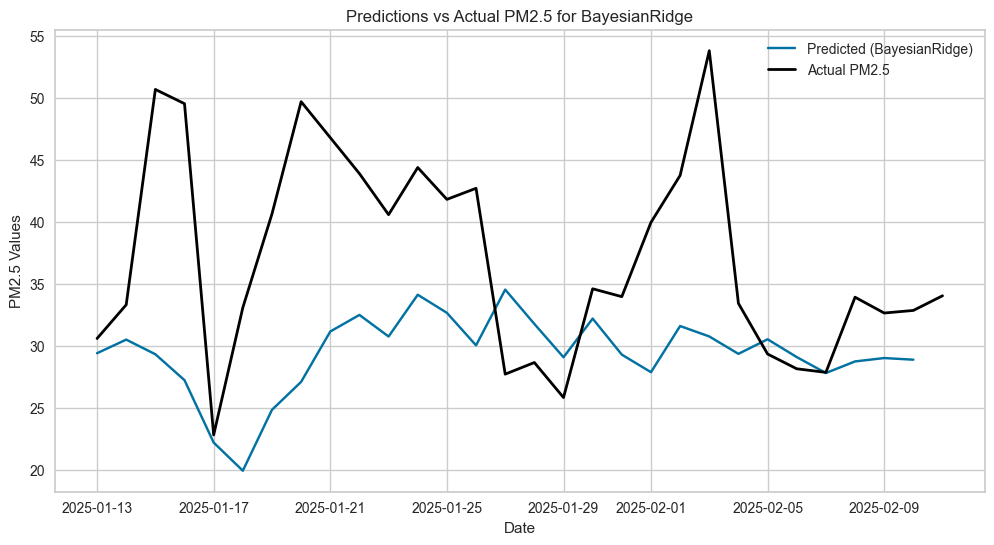

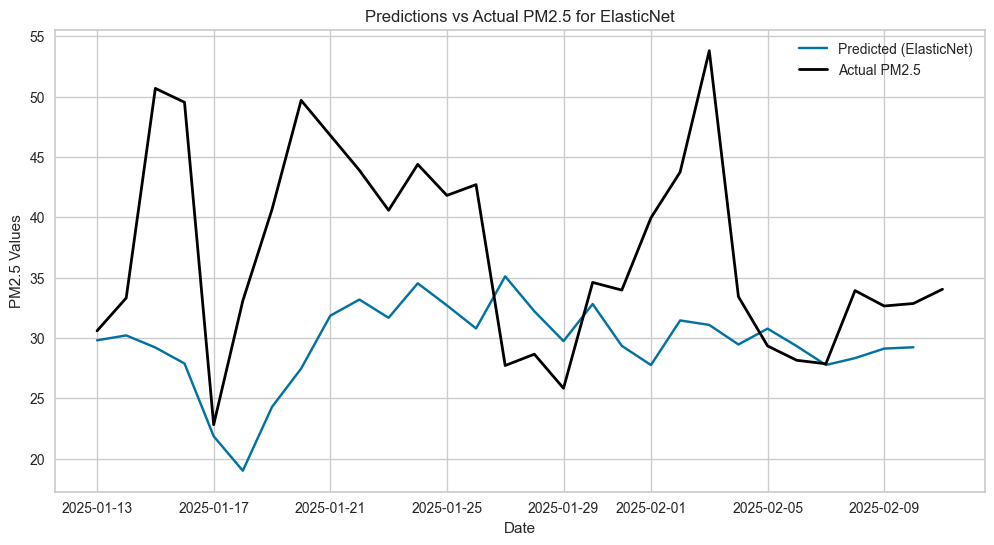

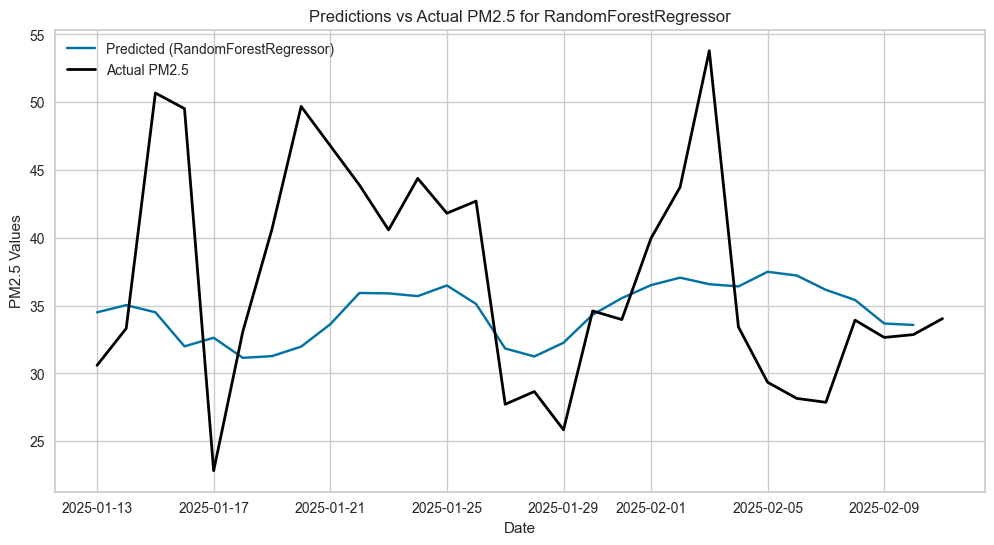

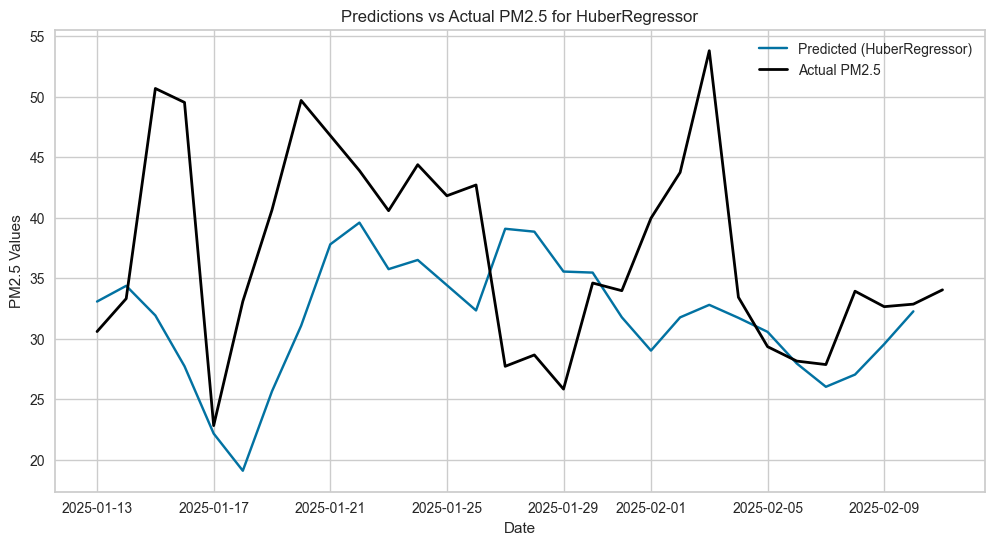

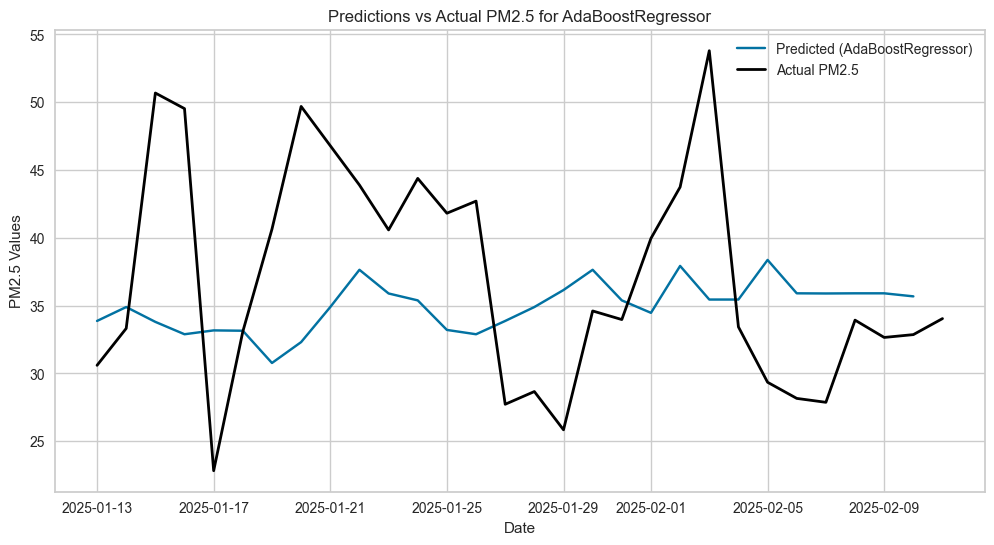

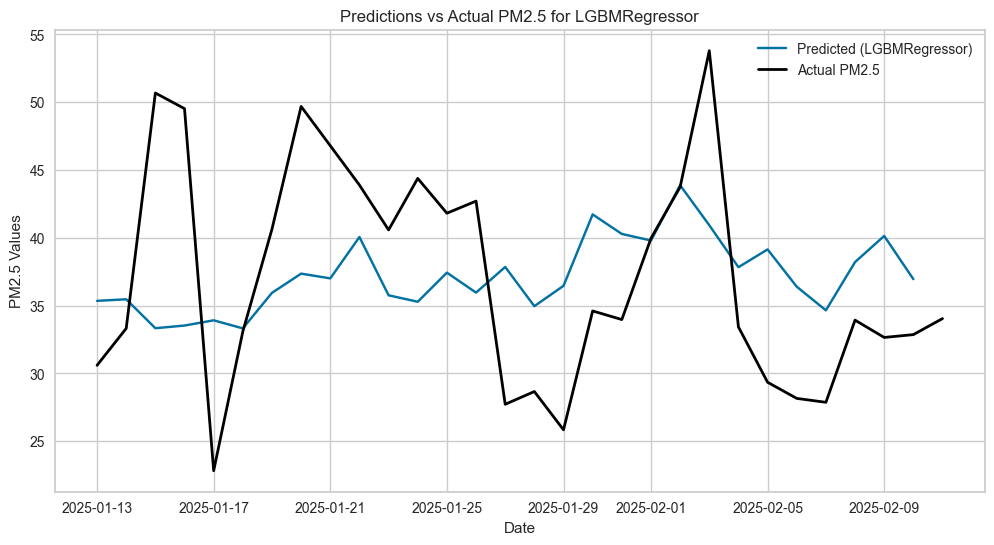

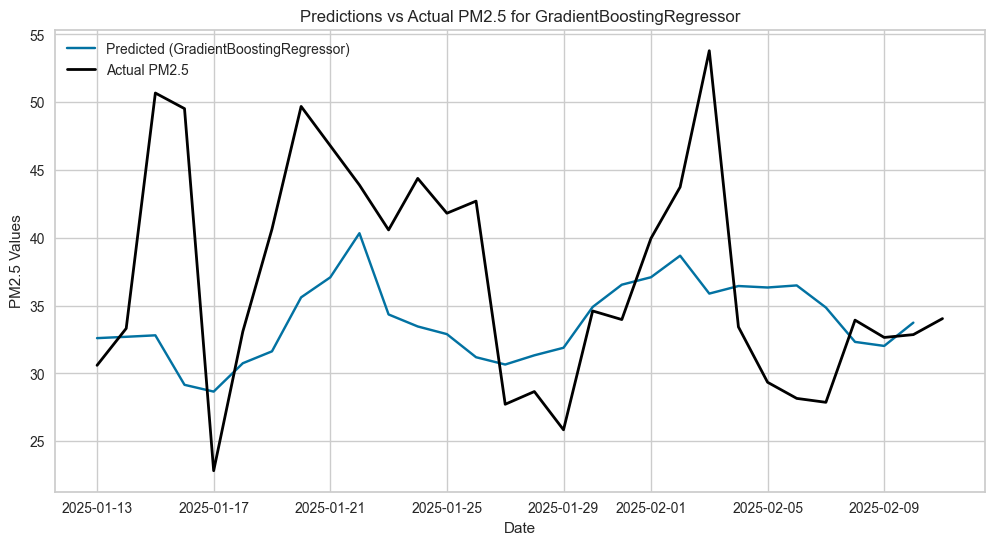

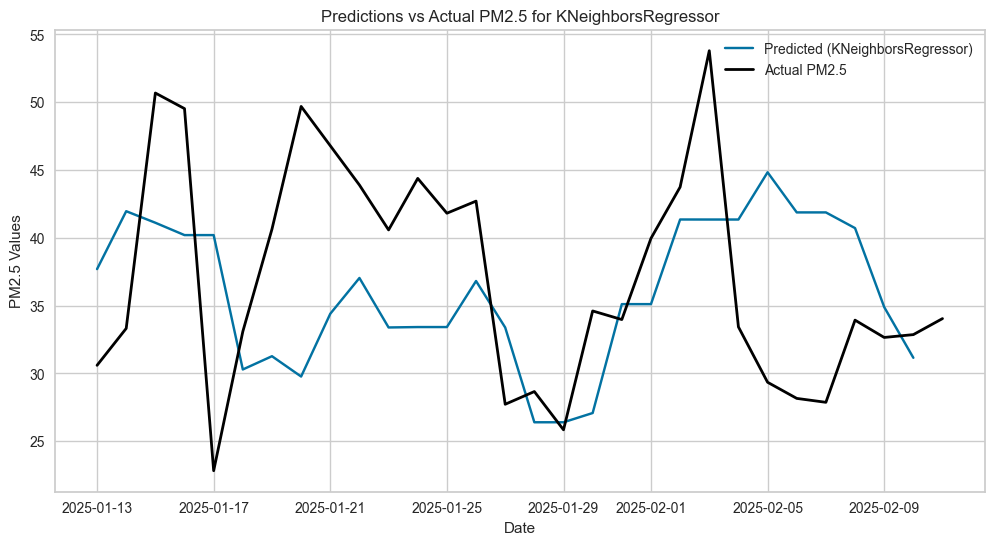

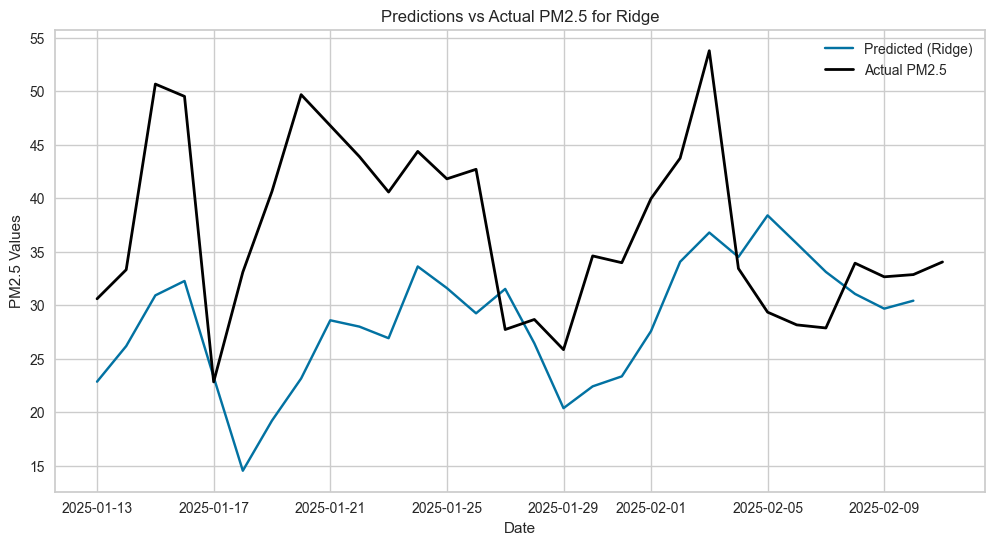

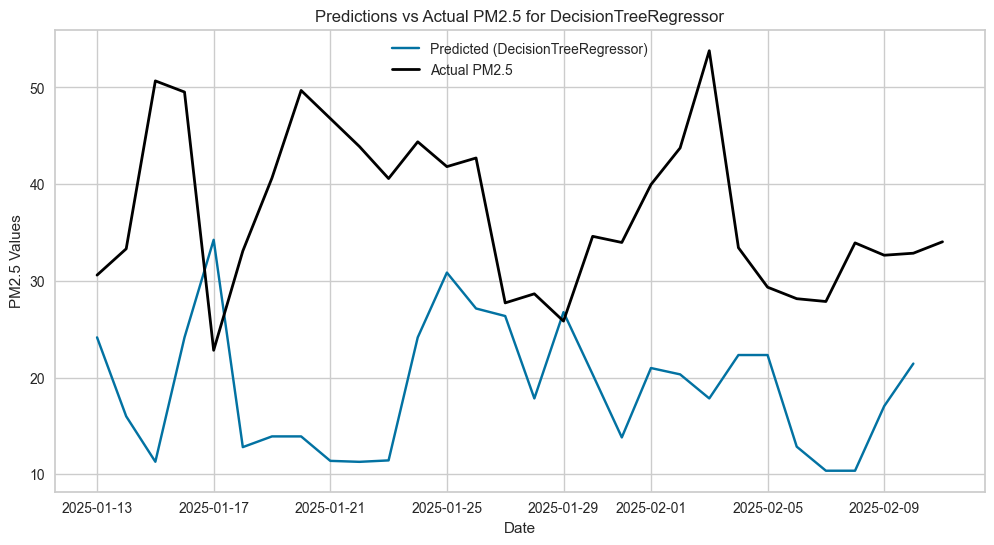

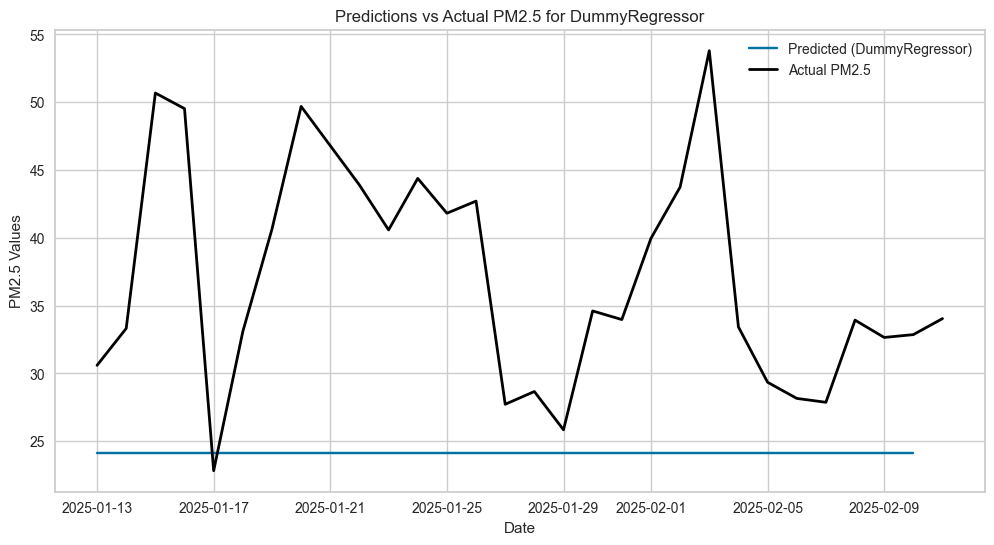

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# แปลง index เป็น datetime และลบเวลาออก
x = data_filtered.copy()
x.index = pd.to_datetime(x.index).normalize()

# เก็บผลลัพธ์ของแต่ละโมเดล
result_dict = {}

# รายชื่อโมเดลทั้งหมดจาก best_list
model_names = {model.__class__.__name__: model for model in best}

start_date = "2025-01-13"
end_date = "2025-02-11"

# วนลูปผ่านทุกโมเดล
for model_name, model in model_names.items():
    print(f"Processing model: {model_name}")

    data_compare = x.loc[:'2025-01-12'].copy()  # ใช้ copy() ป้องกัน Warning
    result = pd.DataFrame()

    for date in pd.date_range(start=start_date, end=end_date, freq="D"):
        # ลบเวลาออกจากวันที่
        date = pd.to_datetime(date).normalize()  # ลบเวลาออกจากตัวแปร date

        # ตรวจสอบว่าใน x มีข้อมูลในวันที่นี้หรือไม่
        if date not in x.index:
            print(f"⚠️ Warning: Date {date} not found in x index.")
            continue

        # ดึงข้อมูลของวันที่ต้องการ
        test_1 = x.loc[[date]].copy()

        # ใส่เข้าไป
        data_compare = pd.concat([data_compare, test_1], axis=0)

        # for i in range(2,rolling_size+1):
        #     test_1[f'pm_2_5_rolling_{i}'] = data_compare['pm_2_5'].rolling(window=i).mean().shift(1)

        # เพิ่ม lag feature
        for i in range(1, lag_size + 1):
            test_1[f'pm_2_5_lag_{i}'] = data_compare['pm_2_5'].shift(i).iloc[-1]

        # ลบค่า NaN ที่เกิดจากการ shift
        test_1 = test_1.dropna()

        # ทำนายค่า
        predict_test_1 = exp1.predict_model(model, data=test_1)

        # อัปเดต data_compare
        predict_test_1.index = [date]  # กำหนด index เป็นวันที่พยากรณ์
        data_compare.loc[date, 'pm_2_5'] = predict_test_1['prediction_label'].values[0]

        # บันทึกผลลัพธ์
        result = pd.concat([result, predict_test_1], axis=0)

    # บันทึกผลลัพธ์ของโมเดลนี้ลง dict
    result_dict[model_name] = result

# --------------------------------------------
# พล็อตกราฟเปรียบเทียบทุกโมเดล
# --------------------------------------------
real_data = x.loc[start_date:end_date]

# วนลูปพล็อตกราฟทีละโมเดล
for model_name, result in result_dict.items():
    plt.figure(figsize=(12, 6))
    
    result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['pm_2_5']], axis=1)
    result_plot.columns = ['Predictions', 'Actual PM2.5']

    plt.plot(result_plot.index, result_plot['Predictions'], label=f"Predicted ({model_name})")
    plt.plot(real_data.index, real_data['pm_2_5'], label="Actual PM2.5", color="black", linewidth=2)
    
    # ตั้งค่ากราฟ
    plt.title(f'Predictions vs Actual PM2.5 for {model_name}')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 Values')
    plt.legend()

    # แสดงกราฟ
    plt.show()

In [54]:
# --------------------------------------------
# คำนวณและแสดงผล Regression Metrics (หลังจากพล็อตกราฟ)
# --------------------------------------------
for model_name, result in result_dict.items():
    y_true = x.loc[start_date:end_date, 'pm_2_5']  # ค่าจริง
    y_pred = result['prediction_label'].shift(-1)  # ค่าพยากรณ์

    # ลบ NaN ที่เกิดจากการ shift
    valid_idx = y_pred.dropna().index
    y_true = y_true.loc[valid_idx]
    y_pred = y_pred.loc[valid_idx]

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    accuracy = 100 - mape  # เปลี่ยนเป็น Accuracy %

    # แสดงค่า Metrics ของโมเดลนี้
    print("\n📊 Model Performance Metrics:")
    print(f"Model: {model_name}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")
    print("-" * 50)


📊 Model Performance Metrics:
Model: OrthogonalMatchingPursuit
R² Score: -1.1323
Mean Absolute Error (MAE): 9.4956
Root Mean Squared Error (RMSE): 12.0184
Mean Absolute Percentage Error (MAPE): 22.91%
Accuracy: 77.09%
--------------------------------------------------

📊 Model Performance Metrics:
Model: LassoLars
R² Score: -0.8668
Mean Absolute Error (MAE): 8.7082
Root Mean Squared Error (RMSE): 11.2454
Mean Absolute Percentage Error (MAPE): 20.88%
Accuracy: 79.12%
--------------------------------------------------

📊 Model Performance Metrics:
Model: ExtraTreesRegressor
R² Score: -0.1277
Mean Absolute Error (MAE): 7.0589
Root Mean Squared Error (RMSE): 8.7403
Mean Absolute Percentage Error (MAPE): 18.52%
Accuracy: 81.48%
--------------------------------------------------

📊 Model Performance Metrics:
Model: Lasso
R² Score: -0.8658
Mean Absolute Error (MAE): 8.7055
Root Mean Squared Error (RMSE): 11.2425
Mean Absolute Percentage Error (MAPE): 20.87%
Accuracy: 79.13%
------------------